In [1]:
# Required imports
import numpy as np
import pandas as pd
from pathlib import Path
import os
import duckdb
import warnings
warnings.filterwarnings('ignore')
%matplotlib widget
import matplotlib.pyplot as plt
import mplcursors  
from pandas import Timestamp

from factor_tools import create_extended_analysis_data

from option_tools import *
from option_backtest_tools import *
from option_strategies import *

In [2]:
'''
create_option_base_data(start_date='2018-01-02',
    end_date='2020-12-31',db_path='wrds_data.db',min_option_liquidity=1)
'''

"\ncreate_option_base_data(start_date='2018-01-02',\n    end_date='2020-12-31',db_path='wrds_data.db',min_option_liquidity=1)\n"

In [3]:
# Analysis parameters
ANALYSIS_PARAMS = {
    'start_date': '2020-01-05',
    'end_date': '2020-03-30',
}

In [5]:
data_df_dic, trading_dates = create_option_analysis_data(
    start_date=ANALYSIS_PARAMS['start_date'],
    end_date=ANALYSIS_PARAMS['end_date'],
    factor_names=['roe'],
    db_path='wrds_data.db',
    factor_data_path='factor_data'
)

Creating analysis data with factors: roe: 100%|██████████| 60/60 [00:00<00:00, 67.18it/s]


In [7]:
# Create strategy instance
strategy = ROEOptionStrategy(
    holding_period_days=5,  # Hold for 5 trading days
    weekly_trade_day=4      # Trade on Fridays
)

In [9]:
option_data_dic = preload_option_data_for_backtest(
    strategy=strategy,
    data_df_dic=data_df_dic,
    trading_dates=trading_dates,
    db_path='wrds_data.db',
    start_date=ANALYSIS_PARAMS['start_date'],
    end_date=ANALYSIS_PARAMS['end_date'],
)

Loading cached option data from Data_all/Option_Cache_Data\ROEOptionStrategy_9b77eb46_20200105_20200330.pkl


In [ ]:
option_data_dic

In [8]:
data_df_dic[Timestamp('2020-01-31 00:00:00')]

,ticker,date,dlyprc,dlyprevprc,dlyret,dlyretmissflg,dlycap,tradingstatusflg,securitytype,sharetype,...,nearest_expiry,furthest_expiry,days_to_nearest_expiry,days_to_furthest_expiry,option_available,lpermno,lpermco,gvkey,iid,roe
permno,,,,,,,,,,,,,,,,,,,,,
10516,ADM,2020-01-31,44.7600,45.8000,-0.022707,NA,24917265.36,A,EQTY,NS,...,2020-01-31,2022-01-21,0.0,721.0,1,10516.0,20207.0,001722,01,0.021518
10517,AAN,2020-01-31,59.3600,62.8000,-0.054777,NA,3986142.72,A,EQTY,NS,...,2020-02-21,2020-08-21,21.0,203.0,1,10517.0,5674.0,001076,01,0.021414
10530,VIVO,2020-01-31,9.8400,10.1000,-0.025743,NA,421437.36,A,EQTY,NS,...,2020-02-21,2020-07-17,21.0,168.0,1,10530.0,8441.0,012433,01,0.021622
10547,CLFD,2020-01-31,12.7200,13.2400,-0.039275,NA,173717.04,A,EQTY,NS,...,2020-02-21,2020-06-19,21.0,140.0,1,10547.0,8458.0,012482,01,0.025530
10550,PDEX,2020-01-31,15.4373,16.0000,-0.035169,NA,59958.47,A,EQTY,NS,...,NaT,NaT,NaN,NaN,0,10550.0,8461.0,012458,01,0.064089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92543,SOL,2020-01-31,1.3095,1.2900,0.015116,NA,12706.08,A,EQTY,AD,...,2020-04-17,2020-07-17,77.0,168.0,0,92543.0,52934.0,279431,90,0.025267
92550,BIP,2020-01-31,54.4000,54.7800,-0.006937,NA,15963843.20,A,EQTY,UG,...,2020-02-21,2020-09-18,21.0,231.0,1,92550.0,52942.0,179216,01,0.017627
92557,LIVE,2020-01-31,7.2900,7.3795,-0.012128,NA,10789.20,A,EQTY,NS,...,NaT,NaT,NaN,NaN,0,92557.0,52950.0,066261,01,0.035399


In [11]:
# Create commission model for options
commission_model = OptionCommissionModel(
    per_contract_fee=0.65,  # $0.65 per contract
    min_commission=1.0,     # $1.00 minimum per trade
    base_fee=0.0            # No base fee
)


In [ ]:


# Create backtest instance
backtest = OptionBacktest(
    cash=100000,
    commission_model=commission_model,
    data_df_dic=data_df_dic,
    trading_dates=trading_dates,
    db_path='wrds_data.db',
    strategy=strategy,
    option_data_dic=option_data_dic
)

# Run backtest
results = backtest.backtest()

Processing dates:   0%|          | 0/59 [00:00<?, ?it/s]

In [13]:
results

{}

ValueError: x and y must have same first dimension, but have shapes (48,) and (60,)

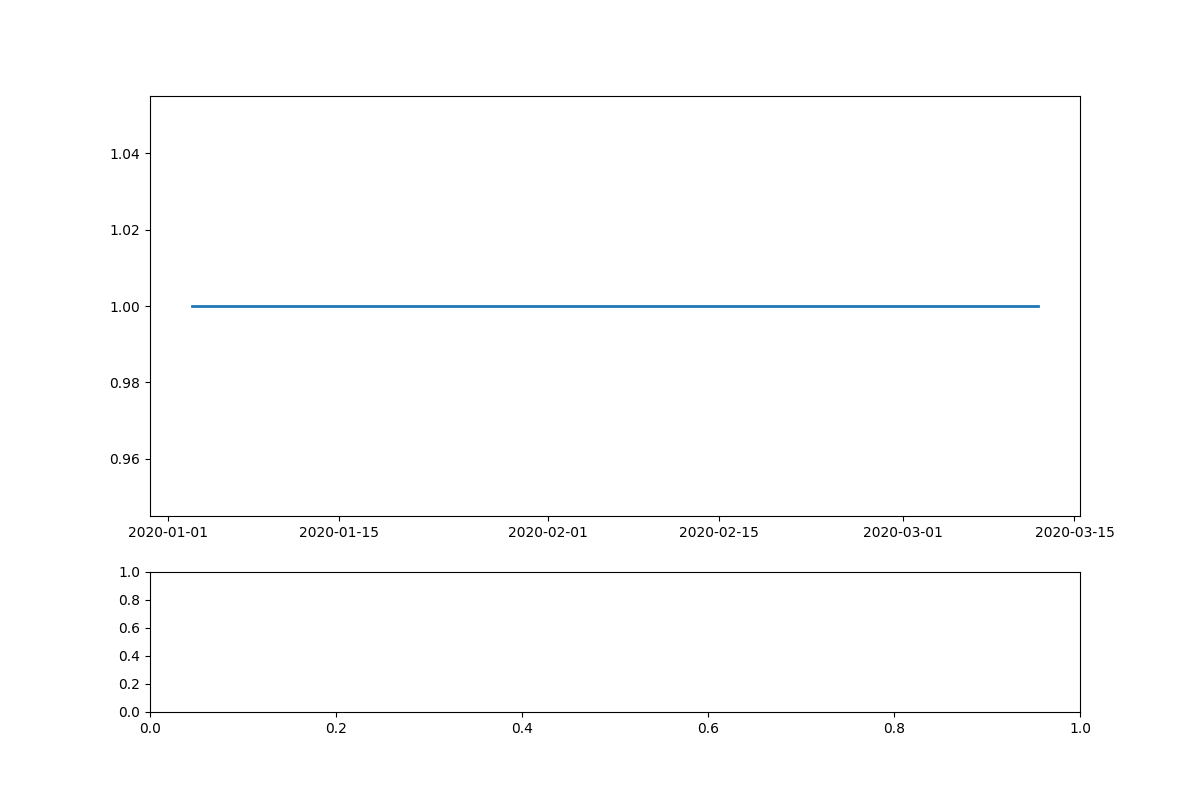

In [12]:
backtest.plot_performance()

In [ ]:
results

{}

In [ ]:
pd.read_parquet('Data_all/Extended_Base_Data/20201229.parquet')

,ticker,date,dlyprc,dlyprevprc,dlyret,dlyretmissflg,dlycap,tradingstatusflg,securitytype,sharetype,dlyclose,dlyopen,dlyprcflg,dlyprevprcflg,dlydelflg,dlydistretflg,dlyfacprc,dlyclose_1,dlyopen_1
permno,,,,,,,,,,,,,,,,,,,
10294,HVT,2020-12-29,28.465,29.0000,-0.018448,NA,43039.08,A,EQTY,NS,NaN,NaN,BA,TR,N,NO,1.0,NaN,NaN
10308,TMP,2020-12-29,70.260,71.1300,-0.012231,NA,1049052.06,A,EQTY,NS,70.26,71.1900,TR,TR,N,NO,1.0,70.26,71.1900
10318,BCPC,2020-12-29,112.920,113.6800,-0.006685,NA,3653074.92,A,EQTY,NS,112.92,113.2900,TR,TR,N,NO,1.0,112.92,113.2900
11499,CECE,2020-12-29,6.710,6.9000,-0.027536,NA,238238.55,A,EQTY,NS,6.71,6.9000,TR,TR,N,NO,1.0,6.71,6.9000
11511,CPSH,2020-12-29,2.760,2.4700,0.117409,NA,36746.64,A,EQTY,NS,2.76,2.5100,TR,TR,N,NO,1.0,2.76,2.5100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93341,BIB,2020-12-29,86.730,88.8000,-0.023311,NA,242844.00,A,FUND,NS,86.73,89.1300,TR,TR,N,NO,1.0,86.73,89.1300
93342,BICK,2020-12-29,36.940,36.4383,0.013769,NA,83115.00,A,FUND,NS,36.94,36.9900,TR,TR,N,NO,1.0,36.94,36.9900
93343,BIS,2020-12-29,23.470,22.9100,0.024444,NA,10467.62,A,FUND,NS,23.47,22.7800,TR,TR,N,NO,1.0,23.47,22.7800


In [ ]:
pd.read_parquet('Data_all/Option_Base_Data/20201229.parquet')

,ticker,date,dlyprc,dlyprevprc,dlyret,dlyretmissflg,dlycap,tradingstatusflg,securitytype,sharetype,...,has_puts,min_call_strike,max_call_strike,avg_call_iv,avg_put_iv,nearest_expiry,furthest_expiry,days_to_nearest_expiry,days_to_furthest_expiry,option_available
permno,,,,,,,,,,,,,,,,,,,,,
10294,HVT,2020-12-29,28.465,29.0000,-0.018448,NA,43039.08,A,EQTY,NS,...,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,0
10308,TMP,2020-12-29,70.260,71.1300,-0.012231,NA,1049052.06,A,EQTY,NS,...,0,70000.0,75000.0,0.322013,NaN,2021-03-19,2021-06-18,80.0,171.0,0
10318,BCPC,2020-12-29,112.920,113.6800,-0.006685,NA,3653074.92,A,EQTY,NS,...,0,105000.0,125000.0,0.280691,NaN,2021-02-19,2021-08-20,52.0,234.0,0
11499,CECE,2020-12-29,6.710,6.9000,-0.027536,NA,238238.55,A,EQTY,NS,...,1,5000.0,15000.0,0.746392,1.208007,2021-01-15,2021-05-21,17.0,143.0,1
11511,CPSH,2020-12-29,2.760,2.4700,0.117409,NA,36746.64,A,EQTY,NS,...,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93341,BIB,2020-12-29,86.730,88.8000,-0.023311,NA,242844.00,A,FUND,NS,...,1,45000.0,135000.0,0.576190,0.625664,2021-01-15,2021-08-20,17.0,234.0,1
93342,BICK,2020-12-29,36.940,36.4383,0.013769,NA,83115.00,A,FUND,NS,...,0,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,0
93343,BIS,2020-12-29,23.470,22.9100,0.024444,NA,10467.62,A,FUND,NS,...,1,12000.0,50000.0,0.690206,0.667140,2021-01-15,2021-05-21,17.0,143.0,1
